In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import pdb

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
# options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 20       # number of epochs to train
lr = 0.01      # learning rate

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = datasets.CIFAR10(root='/scratch/vr1059/cifar10', train=True, download=True, transform=data_transform)
testset = datasets.CIFAR10(root='/scratch/vr1059/cifar10', train=True, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


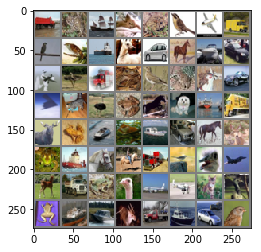

In [4]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

imgs = np.transpose(torchvision.utils.make_grid(images), (1, 2, 0)) * 0.5 + 0.5
plt.imshow(torchvision.utils.make_grid(imgs))

In [5]:
# PyTorch Lightning Module

class ConvNet(pl.LightningModule):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv_2 = nn.Conv2d(16, 128, 5)
        self.linear_1 = nn.Linear(128*5*5, 64)
        self.linear_2 = nn.Linear(64, 10)

    def forward(self, x):
        # input has shape [bs, 3, 32, 32]
        layer_1 = self.pool(torch.tanh(self.conv_1(x)))
        layer_2 = self.pool(torch.tanh(self.conv_2(layer_1)))
        flatten = layer_2.view(-1, 128*5*5)
        output = self.linear_2(torch.tanh(self.linear_1(flatten)))
        
        return output

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        return {'loss': F.cross_entropy(y_hat, y)}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        
        pred = y_hat.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct = pred.eq(y.data.view_as(pred)).sum()
        
        return {'val_loss': F.cross_entropy(y_hat, y), 'correct': correct, 'bs': y.shape[0]}

    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_set_size = torch.tensor([x['bs'] for x in outputs]).sum()
        avg_accuracy = torch.stack([x['correct'] for x in outputs]).sum().item()/(1. * val_set_size.item())
        return {'avg_val_loss': avg_loss, 'avg_val_acc': 100*avg_accuracy}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        return torch.optim.SGD(self.parameters(), lr=lr)

    @pl.data_loader
    def tng_dataloader(self):
        return train_loader

    @pl.data_loader
    def val_dataloader(self):
        return test_loader

In [6]:
model = ConvNet()

In [14]:
# most basic trainer, uses good defaults
trainer = Trainer(gpus=[0, 1], max_nb_epochs=20, distributed_backend='dp') 

VISIBLE GPUS: '0,1'
gpu available: True, used: True


In [15]:
trainer.fit(model) 

  0%|          | 0/5 [00:00<?, ?it/s]

       Name       Type  Params
0    conv_1     Conv2d    1216
1      pool  MaxPool2d       0
2    conv_2     Conv2d   51328
3  linear_1     Linear  204864
4  linear_2     Linear     650


/home/vr1059/py3.6.3/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TypeError: zip argument #1 must support iteration

In [26]:
torch.save(model.state_dict(), '/scratch/vr1059/cifar10/best_model')

In [53]:
filters = []
k = 0
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        wts = m.weight.data
        for i in range(wts.shape[0]):
            # normalize between the range [0, 1]
            minimum = torch.min(wts[i])
            r = torch.max(wts[i]) - minimum
            filters.append((wts[i] - minimum)/r)
        k += 1
    if k == 1:
        break

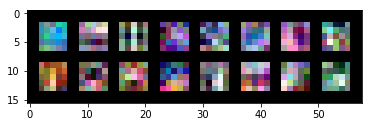

In [56]:
plt.imshow(np.transpose(torchvision.utils.make_grid(filters).cpu().numpy(), (1, 2, 0)))